In [0]:
# Downloading the test and training the data
!wget -q https://l1nna.com/372/Assignment/A2-3/train.csv
!wget -q https://l1nna.com/372/Assignment/A2-3/test.csv

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Reading the csv files into the variables using pandas so they can be used in the notebook
xy_train = pd.read_csv('train.csv')
x_test  = pd.read_csv('test.csv')


In [14]:
# Converts review as the input named x from training dataset for the model. You do not want ID as an input as it has no use.
x = xy_train.review

# Converts rating as the ouput named y from training dataset for the model
y = xy_train.rating
print(y.value_counts())

# Pipeline helps in sequentual manner for transformation/estimator
#     vect: Converts the text into a matrix of token counts and build a vocabulary of known words. This helps in encoding new texts using that vocabulary. 

#     tfidf: Used in conjuction with vect to create inverse text frequencies - downscales words that appear a lot across documents as words like “the” will
#     appear many times and their large counts will not be very meaningful in the encoded vectors

#     clf: Support Vector Machine model is our model for machine learning. class_weight='balanced' automatically adjust weights inversely proportional to 
#     class frequencies (tfidf) in the input data . The idea behind this is that to increase the penalty for misclassifying minority classes to prevent them
#     from being “overwhelmed” by the majority class.


# -------------- RELEVANT NEW STUFF -------------- #

# We Choose script A2 has it has already very high F1-mean score.
# With changing different kernels, sigmoid was found to work the best through trial and error.
# 

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', BaggingClassifier(SVC(class_weight='balanced', kernel ='sigmoid'))),
])

# Parameter range for our SVM model - needed for GridSearchCV
#   vect__max_features: Number of maximum  features
#   vect__analyzer: The feature should be made of word n-gram
#   tfidf__use_idf: with or without inverse document frequency
parameters = {
    'vect__max_features': [100, 500, 1000, 5000, 10000, 120000],
    'vect__analyzer': ['word',],
    'vect__ngram_range': ((1, 2),(1, 3)), # unigrams or bigrams or trigrams etc
    'tfidf__use_idf': (True, False),
#     'clf__C': [0.1,1],
#     'tfidf__norm': ('l1', 'l2'),
#     'clf__max_iter': (20,),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

# Our model will be scored based on f1 (as required by the assignment guidelines) and accuracy.
scoring = ['f1', 'accuracy']

# Split is the integer output of the 80% of the training data eg split = 4978
split = int(len(x) * 0.8)

# GridSearchCV: parameter tuning that will methodically build and 
#               evaluate a model for each combination of algorithm parameters specified in a grid.
#   cv : Divide the training dataset into 80% for training the model and 20% to testing the model to see how it performs with different parameters.
#   n_jobs = 20 - Running twnety jobs in parallel
#   verbose : give messages
#   scoring : Evaluate the test set based on the variable scoring on the test set
#   refit='f1' : Refit an estimator using the parameters setting with best f1 score on the whole dataset. This allows us to find a better model
#                by choosing the parameters that give best f1 score.
#   return_train_score : Shows the training scores to get insights on how different parameter settings impact the overfitting/underfitting trade-off
grid_search = GridSearchCV(
    pipeline, param_grid=parameters, verbose=3, cv=[(np.arange(0, split), np.arange(split, len(x)))], 
    refit='f1', scoring=scoring, n_jobs=20, return_train_score=True)

# the average of all cv folds for a single combination of the parameters
#print('best score {}'.format(grid_search.best_score_))

# fitting the model with the data to find the best hypertuning parameters
grid_search.fit(x, y)



1    5452
0     771
Name: rating, dtype: int64
Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=20)]: Done   3 out of  24 | elapsed:  5.6min remaining: 39.1min
[Parallel(n_jobs=20)]: Done  12 out of  24 | elapsed: 23.4min remaining: 23.4min
[Parallel(n_jobs=20)]: Done  21 out of  24 | elapsed: 29.6min remaining:  4.2min
[Parallel(n_jobs=20)]: Done  24 out of  24 | elapsed: 30.3min finished


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4975, 4976, 4977]),
                  array([4978, 4979, 4980, ..., 6220, 6221, 6222]))],
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
    

In [15]:
# Check the best parameter combinatiom
print('best parameter {}'.format(grid_search.best_params_))

y_pred = grid_search.predict(x)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
cm = confusion_matrix(y, y_pred)
print(cm)

print('Precision is: {}'.format(precision_score(y, y_pred)))
print('Recall is: {}'.format(recall_score(y, y_pred)))
print('F1 score is: {}'.format(f1_score(y, y_pred)))

print('mean train accuracy {}'.format(grid_search.cv_results_['mean_train_accuracy'] ))
print('mean test accuracy {}'.format(grid_search.cv_results_['mean_test_accuracy'] ))

best parameter {'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__max_features': 120000, 'vect__ngram_range': (1, 3)}
[[ 738   33]
 [  17 5435]]
Precision is: 0.9939648866130212
Recall is: 0.9968818782098312
F1 score is: 0.9954212454212453
mean train accuracy [0.6733628  0.66633186 0.81498594 0.81337887 0.87022901 0.8740458
 0.96223383 0.96183206 0.97730012 0.97730012 0.99136199 0.9949779
 0.65146645 0.65126557 0.76074729 0.77038971 0.81679389 0.81699478
 0.89835275 0.89574126 0.91723584 0.9164323  0.95861792 0.96564885]
mean test accuracy [0.70120482 0.69317269 0.83212851 0.82248996 0.86184739 0.87309237
 0.92048193 0.9124498  0.93333333 0.93092369 0.93253012 0.93413655
 0.65381526 0.65542169 0.78072289 0.78554217 0.80963855 0.82971888
 0.88674699 0.87710843 0.89558233 0.89638554 0.92128514 0.92771084]


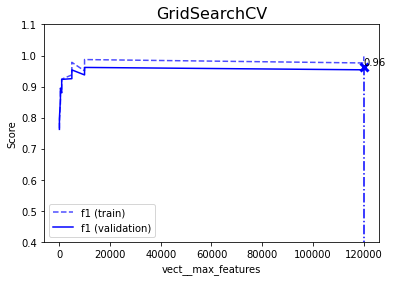

In [17]:
# let's visualize hyperparameters against performance

from matplotlib import pyplot as plt

selected_parameter = 'vect__max_features'
results = grid_search.cv_results_

plt.figure()
plt.title("GridSearchCV",
          fontsize=16)

plt.xlabel(selected_parameter)
plt.ylabel("Score")

ax = plt.gca()
ax.set_ylim(0.4, 1.1)


# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_'+ selected_parameter].data, dtype=float)

scorer = 'f1'
color ='b'
for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
    sample_score_mean = [x for _,x in sorted(zip(X_axis,sample_score_mean))]
    ax.plot(sorted(X_axis), sample_score_mean, style, color=color,
            alpha=1 if sample == 'test' else 0.7,
            label="%s (%s)" % (scorer, sample if sample == 'train' else 'validation'))

best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
best_score = results['mean_test_%s' % scorer][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))
    

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [0]:
# generate submission

# Outputting the predicted y value for the testing data based on our best model created by gridSearch
#     squeeze allows us to remove the array or subset of the dimensions of length 1 
#     basically means that you removed the data embedded in array's starting index.
y_predict = np.squeeze(grid_search.predict(x_test.review))

# Convert output by adding the predicted id and rating for the test and add to filet for sample_submission.csv
pd.DataFrame(
    {'id': x_test.id, 'rating':y_predict}).to_csv('sample_submission.csv', index=False)